<a href="https://colab.research.google.com/github/JamainePillay/Image-processing-projects/blob/main/COMP702_Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

# Define the file name and extract path
zip_path = "/content/Dataset-my own.zip"
extract_path = "coins_datasets"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

# List all subfolders (coin categories)
import os

for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:10]:
        print(f"{subindent}{f}")

Extraction complete!
coins_datasets/
  Dataset-my own/
    Dataset/
      50c/
        20250527_212716 (57).jpg
        20250527_212607 (33).jpg
        50c_O1.jpg
        50c_front4.jpeg
        20250527_212641.jpg
        20250527_212728.jpg
        20250527_212643 (14).jpg
        20250527_212744 (43).jpg
        20250527_212632 (21).jpg
        20250527_212634(0) (19).jpg
      10c/
        download (18).jfif
        download (14).jfif
        20250529_233722.jpg
        20250529_233731.jpg
        20250529_233530.jpg
        20250529_233627.jpg
        20250529_233607.jpg
        20250529_233544.jpg
        20250529_233616.jpg
        download (16).jfif
      R2/
        20250527_213011.jpg
        R2_O1.jpg
        download (4).jfif
        20250527_213558.jpg
        20250527_213549.jpg
        20250527_213544.jpg
        20250527_213633.jpg
        20250527_213556.jpg
        20250527_213601.jpg
        20250527_213013.jpg
      5c/
        aug_0_1967.jpg
        5c_front3.jpg


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from tqdm import tqdm


In [ ]:
def load_dataset(dataset_path):
    X = []
    y = []
    paths = []
    classes = os.listdir(dataset_path)

    for label in classes:
        class_path = os.path.join(dataset_path, label)
        if not os.path.isdir(class_path):
            continue

        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (128, 128))  # Resize for uniformity
            X.append(img)
            y.append(label)
            paths.append(img_path)

    return np.array(X), np.array(y) , paths


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/images (5).jfif


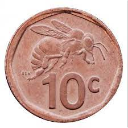

Loaded 447 images from 7 classes


In [ ]:
X, y , z = load_dataset("/content/coins_datasets/Dataset-my own/Dataset")
import cv2
from google.colab.patches import cv2_imshow
x = 142
print(y[x])
print("File path:", z[x])
cv2_imshow(X[x])
cv2.waitKey(0)  # Wait for key press
cv2.destroyAllWindows()

print(f"Loaded {len(X)} images from {len(set(y))} classes")



In [ ]:
def preprocess_image(original_image):
    import cv2
    import numpy as np


    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    denoised = cv2.GaussianBlur(gray, (5, 5), 0)
    enhanced = cv2.equalizeHist(gray)
    # Step 3: CLAHE for contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast_img = clahe.apply(enhanced)

    # Step 4: Sharpening filter
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(contrast_img, -1, sharpen_kernel)

    # Step 5: Gaussian Blur
    blurred = cv2.GaussianBlur(sharpened, (5, 5), 0)
    #blurred = cv2.bilateralFilter(sharpened, 9, 75, 75)

    return {
        'original': original_image,
        'blurred': blurred
    }


100%|██████████| 447/447 [00:00<00:00, 3130.29it/s]


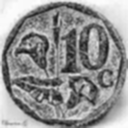


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/download (11).jfif


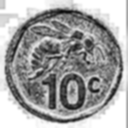


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/images (5).jfif


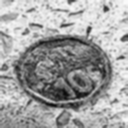


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/20250529_233833.jpg


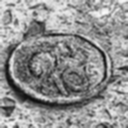


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/20250529_233529.jpg


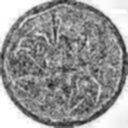


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/download (3).jfif


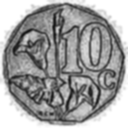


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/download (6).jfif


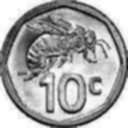


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/download (-4).jfif


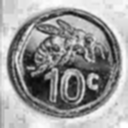


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/images (3).jfif


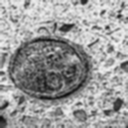


10c
File path: /content/coins_datasets/Dataset-my own/Dataset/10c/20250529_233620.jpg


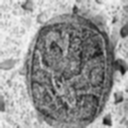


R2
File path: /content/coins_datasets/Dataset-my own/Dataset/R2/20250527_213011.jpg


In [ ]:
X_preprocessed = []  # empty list to store processed images

for img in tqdm(X):  # loop through each image with progress bar
    processed_img = preprocess_image(img)  # apply your preprocessing function
    X_preprocessed.append(processed_img)   # store the result


x = 141
for x in range(x , x + 10):
  cv2_imshow(X_preprocessed[x]["blurred"])
  print("")
  print(y[x])
  print("File path:", z[x])
  #cv2_imshow(X_preprocessed[x])





In [ ]:
def segment_coin(preprocessed_image, original_image, visualize=False):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    height, width = preprocessed_image.shape

    # Step 1: Thresholding (Otsu with adaptive fallback)
    _, binary = cv2.threshold(preprocessed_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    if np.sum(binary == 255) < 0.01 * binary.size:
        binary = cv2.adaptiveThreshold(preprocessed_image, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 15, 3)

    # Step 2: Morphological closing
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 3: Contour detection
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coin_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5000]

    if not coin_contours:
        if visualize:
            print("No valid contour found.")
        blank = np.zeros_like(original_image)
        return blank, None

    largest_contour = max(coin_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Step 4: Padding
    pad = int(min(w, h) * 0.1)
    x = max(x - pad, 0)
    y = max(y - pad, 0)
    w = min(w + 2 * pad, width - x)
    h = min(h + 2 * pad, height - y)

    # Step 5: Mask and crop
    mask = np.zeros_like(preprocessed_image)
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)
    masked_image = cv2.bitwise_and(original_image, original_image, mask=mask)
    cropped = masked_image[y:y+h, x:x+w]

    # Step 6: Visualization
    if visualize:
        fig, axs = plt.subplots(1, 4, figsize=(20, 4))
        axs[0].imshow(preprocessed_image, cmap='gray')
        axs[0].set_title("Preprocessed")
        axs[0].axis('off')

        axs[1].imshow(binary, cmap='gray')
        axs[1].set_title("Thresholded")
        axs[1].axis('off')

        axs[2].imshow(mask, cmap='gray')
        axs[2].set_title("Coin Mask")
        axs[2].axis('off')

        axs[3].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        axs[3].set_title("Segmented Coin")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

    return cropped, largest_contour


 71%|███████   | 318/447 [00:00<00:00, 1596.73it/s]

No valid contour found.
No valid contour found.
No valid contour found.


100%|██████████| 447/447 [00:00<00:00, 1571.93it/s]

No valid contour found.


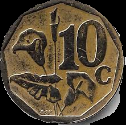

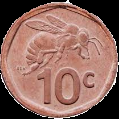

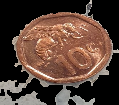

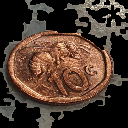

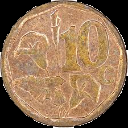

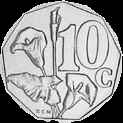

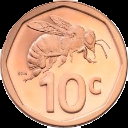

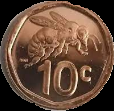

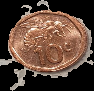

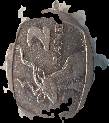

In [ ]:
X_segmented = []

for img in tqdm(X_preprocessed):  # X contains the original images
    #preprocessed = preprocesss_image(img)
    #enhanced = preprocessed['enhanced']  # this is a NumPy array
    segmented_img,contour= segmentt_coin(img["blurred"], img['original'])  # pass only the enhanced and original
    if segmented_img is not None:
        X_segmented.append(segmented_img)

x=142
for x in range(x,x+10):
  cv2_imshow(X_segmented[x])





In [ ]:
from skimage.feature import local_binary_pattern, hog

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(128, 128, 3))
cnn_model = Model(inputs=base_model.input, outputs=base_model.output)
def extract_cnn_features(image):
    resized = cv2.resize(image, (128, 128))
    img_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    img_array = np.expand_dims(img_rgb, axis=0).astype(np.float32)
    preprocessed = preprocess_input(img_array)
    features = cnn_model.predict(preprocessed, verbose=1)
    return features.flatten()



In [ ]:
#X_features = extract_features(X_preprocessed)
  # empty list to store processed images
X_features = []
for img in tqdm(X_segmented):  # loop through each image with progress bar
    feature = extract_cnn_features(img)  # apply your preprocessing function
    X_features.append(feature)   # store the result

  0%|          | 0/447 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 1/447 [00:02<19:44,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 3/447 [00:02<05:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 4/447 [00:02<03:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 5/447 [00:03<02:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 6/447 [00:03<02:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 7/447 [00:03<01:46,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 8/447 [00:03<01:27,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  2%|▏         | 9/447 [00:03<01:16,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 10/447 [00:03<01:08,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 11/447 [00:03<01:01,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 12/447 [00:03<00:57,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 14/447 [00:03<00:45,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▎         | 16/447 [00:04<00:39, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 18/447 [00:04<00:36, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 20/447 [00:04<00:38, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 22/447 [00:04<00:39, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▌         | 24/447 [00:04<00:36, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 26/447 [00:04<00:34, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▋         | 28/447 [00:05<00:32, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 30/447 [00:05<00:32, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 32/447 [00:05<00:32, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 34/447 [00:05<00:32, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 36/447 [00:05<00:31, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▊         | 38/447 [00:05<00:33, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 40/447 [00:06<00:34, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 42/447 [00:06<00:35, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 44/447 [00:06<00:33, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 10%|█         | 46/447 [00:06<00:33, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█         | 48/447 [00:06<00:32, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 50/447 [00:06<00:35, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 52/447 [00:07<00:37, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 54/447 [00:07<00:34, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 13%|█▎        | 56/447 [00:07<00:37, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 58/447 [00:07<00:40,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 59/447 [00:07<00:40,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|█▎        | 60/447 [00:08<00:42,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▎        | 61/447 [00:08<00:42,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 62/447 [00:08<00:43,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 63/447 [00:08<00:42,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 64/447 [00:08<00:44,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▍        | 65/447 [00:08<00:43,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 15%|█▍        | 66/447 [00:08<00:45,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 15%|█▍        | 67/447 [00:08<00:46,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▌        | 68/447 [00:08<00:48,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▌        | 69/447 [00:09<00:48,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 70/447 [00:09<00:48,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 71/447 [00:09<00:46,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|█▌        | 72/447 [00:09<00:47,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▋        | 73/447 [00:09<00:47,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 17%|█▋        | 74/447 [00:09<00:49,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 76/447 [00:09<00:42,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 77/447 [00:10<00:41,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 79/447 [00:10<00:36, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 81/447 [00:10<00:37,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 82/447 [00:10<00:38,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 84/447 [00:10<00:36,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 86/447 [00:10<00:35, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 88/447 [00:11<00:32, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 90/447 [00:11<00:30, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 92/447 [00:11<00:33, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 94/447 [00:11<00:31, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 96/447 [00:11<00:32, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 98/447 [00:11<00:32, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 100/447 [00:12<00:31, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 102/447 [00:12<00:31, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 104/447 [00:12<00:32, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▎       | 106/447 [00:12<00:29, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 108/447 [00:12<00:31, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 110/447 [00:13<00:31, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 112/447 [00:13<00:31, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 114/447 [00:13<00:32, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 116/447 [00:13<00:30, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▋       | 118/447 [00:13<00:30, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 120/447 [00:13<00:28, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 122/447 [00:14<00:27, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 124/447 [00:14<00:27, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 126/447 [00:14<00:26, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▊       | 128/447 [00:14<00:25, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 130/447 [00:14<00:26, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 132/447 [00:14<00:25, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 134/447 [00:15<00:26, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 136/447 [00:15<00:27, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 138/447 [00:15<00:29, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███▏      | 140/447 [00:15<00:29, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 142/447 [00:15<00:29, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 144/447 [00:16<00:28, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 146/447 [00:16<00:28, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 148/447 [00:16<00:27, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 150/447 [00:16<00:26, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 152/447 [00:16<00:28, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 154/447 [00:17<00:27, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 156/447 [00:17<00:25, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 158/447 [00:17<00:24, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 160/447 [00:17<00:26, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 162/447 [00:17<00:26, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 164/447 [00:17<00:27, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 166/447 [00:18<00:27, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 168/447 [00:18<00:25, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 170/447 [00:18<00:25, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 172/447 [00:18<00:25, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 174/447 [00:18<00:25, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 176/447 [00:19<00:24, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 178/447 [00:19<00:25, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 180/447 [00:19<00:25, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 182/447 [00:19<00:24, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 184/447 [00:19<00:24, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 42%|████▏     | 186/447 [00:20<00:26,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 42%|████▏     | 188/447 [00:20<00:29,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 189/447 [00:20<00:29,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 190/447 [00:20<00:30,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 191/447 [00:20<00:31,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 43%|████▎     | 192/447 [00:20<00:31,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 193/447 [00:20<00:30,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 194/447 [00:21<00:29,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▎     | 195/447 [00:21<00:30,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 196/447 [00:21<00:31,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 197/447 [00:21<00:30,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▍     | 198/447 [00:21<00:29,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 45%|████▍     | 199/447 [00:21<00:31,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▍     | 200/447 [00:21<00:30,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▍     | 201/447 [00:21<00:30,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 202/447 [00:22<00:31,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▌     | 203/447 [00:22<00:28,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 205/447 [00:22<00:24, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 206/447 [00:22<00:24,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 208/447 [00:22<00:23,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 210/447 [00:22<00:21, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 212/447 [00:22<00:20, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 214/447 [00:23<00:20, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 216/447 [00:23<00:22, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 218/447 [00:23<00:21, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 220/447 [00:23<00:20, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 222/447 [00:23<00:19, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 224/447 [00:24<00:20, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 226/447 [00:24<00:22,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 228/447 [00:24<00:21, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████▏    | 230/447 [00:24<00:20, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 232/447 [00:24<00:18, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 234/447 [00:24<00:17, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 236/447 [00:25<00:17, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 238/447 [00:25<00:19, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▎    | 240/447 [00:25<00:20,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 242/447 [00:25<00:21,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 243/447 [00:25<00:21,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 245/447 [00:26<00:19, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 247/447 [00:26<00:20,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 249/447 [00:26<00:20,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 251/447 [00:26<00:19,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 253/447 [00:26<00:18, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 255/447 [00:27<00:17, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 257/447 [00:27<00:18, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 259/447 [00:27<00:18, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 261/447 [00:27<00:18, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 263/447 [00:27<00:18,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 264/447 [00:28<00:18,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 265/447 [00:28<00:18,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 266/447 [00:28<00:19,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 267/447 [00:28<00:19,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 268/447 [00:28<00:19,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 269/447 [00:28<00:19,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 271/447 [00:28<00:18,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 272/447 [00:28<00:18,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 273/447 [00:28<00:18,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 275/447 [00:29<00:17,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 276/447 [00:29<00:17,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 277/447 [00:29<00:17,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 278/447 [00:29<00:18,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 279/447 [00:29<00:18,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 280/447 [00:29<00:18,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 282/447 [00:29<00:16,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▎   | 284/447 [00:30<00:16, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 285/447 [00:30<00:16,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 287/447 [00:30<00:14, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 289/447 [00:30<00:15, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 291/447 [00:30<00:13, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 293/447 [00:30<00:13, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 295/447 [00:31<00:13, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 297/447 [00:31<00:13, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 299/447 [00:31<00:13, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 301/447 [00:31<00:13, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 303/447 [00:31<00:14, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 305/447 [00:32<00:13, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▊   | 307/447 [00:32<00:13, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 69%|██████▉   | 309/447 [00:32<00:15,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 310/447 [00:32<00:15,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|██████▉   | 311/447 [00:32<00:16,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|██████▉   | 312/447 [00:32<00:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████   | 313/447 [00:33<00:16,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|███████   | 314/447 [00:33<00:15,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|███████   | 315/447 [00:33<00:15,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 316/447 [00:33<00:15,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 317/447 [00:33<00:15,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 318/447 [00:33<00:16,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 71%|███████▏  | 319/447 [00:33<00:16,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 320/447 [00:33<00:16,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 321/447 [00:34<00:16,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 322/447 [00:34<00:16,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 72%|███████▏  | 323/447 [00:34<00:16,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 324/447 [00:34<00:16,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 325/447 [00:34<00:16,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 326/447 [00:34<00:15,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 328/447 [00:34<00:13,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 330/447 [00:35<00:11, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 332/447 [00:35<00:10, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 334/447 [00:35<00:10, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 336/447 [00:35<00:10, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 338/447 [00:35<00:09, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 340/447 [00:36<00:10, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 342/447 [00:36<00:10, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 344/447 [00:36<00:09, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 346/447 [00:36<00:10,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 348/447 [00:36<00:10,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 350/447 [00:37<00:09,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▊  | 352/447 [00:37<00:09,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 353/447 [00:37<00:09,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 354/447 [00:37<00:09,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 356/447 [00:37<00:08, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 358/447 [00:37<00:09,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 359/447 [00:37<00:09,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 360/447 [00:38<00:09,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 362/447 [00:38<00:08, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 364/447 [00:38<00:07, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 366/447 [00:38<00:07, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 368/447 [00:38<00:08,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 369/447 [00:38<00:08,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 370/447 [00:39<00:08,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 371/447 [00:39<00:08,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 372/447 [00:39<00:08,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 374/447 [00:39<00:07,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 375/447 [00:39<00:07,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 376/447 [00:39<00:07,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 377/447 [00:39<00:07,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 378/447 [00:39<00:07,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 379/447 [00:40<00:07,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 381/447 [00:40<00:06, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 382/447 [00:40<00:06,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 383/447 [00:40<00:06,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 385/447 [00:40<00:05, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 387/447 [00:40<00:05, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 389/447 [00:40<00:05, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 391/447 [00:41<00:05,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 393/447 [00:41<00:05,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 395/447 [00:41<00:05,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 397/447 [00:41<00:05,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 398/447 [00:41<00:05,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 399/447 [00:42<00:05,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 400/447 [00:42<00:05,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 401/447 [00:42<00:05,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 403/447 [00:42<00:04,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 404/447 [00:42<00:04,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 405/447 [00:42<00:04,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 407/447 [00:42<00:03, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 409/447 [00:43<00:03, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 411/447 [00:43<00:03,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 413/447 [00:43<00:03, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 415/447 [00:43<00:03,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 417/447 [00:43<00:02, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 419/447 [00:44<00:02, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 421/447 [00:44<00:02,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 423/447 [00:44<00:02,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▌| 425/447 [00:44<00:02,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▌| 426/447 [00:44<00:02,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 96%|█████████▌| 427/447 [00:44<00:02,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 428/447 [00:45<00:02,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▌| 429/447 [00:45<00:02,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 430/447 [00:45<00:02,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▋| 431/447 [00:45<00:01,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 97%|█████████▋| 433/447 [00:45<00:01,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 434/447 [00:45<00:01,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 435/447 [00:45<00:01,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 436/447 [00:45<00:01,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 437/447 [00:46<00:01,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 438/447 [00:46<00:01,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 439/447 [00:46<00:00,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 98%|█████████▊| 440/447 [00:46<00:00,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▊| 441/447 [00:46<00:00,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 99%|█████████▉| 442/447 [00:46<00:00,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|█████████▉| 443/447 [00:46<00:00,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 444/447 [00:46<00:00,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


100%|█████████▉| 445/447 [00:47<00:00,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


100%|█████████▉| 446/447 [00:47<00:00,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|██████████| 447/447 [00:47<00:00,  9.44it/s]



=== Random Forest ===
Accuracy: 0.8222222222222222
              precision    recall  f1-score   support

         10c       0.75      0.80      0.77        15
         20c       1.00      0.67      0.80         9
         50c       0.86      0.75      0.80        16
          5c       0.71      0.89      0.79        19
          R1       0.91      1.00      0.95        10
          R2       0.89      0.73      0.80        11
          R5       0.90      0.90      0.90        10

    accuracy                           0.82        90
   macro avg       0.86      0.82      0.83        90
weighted avg       0.84      0.82      0.82        90



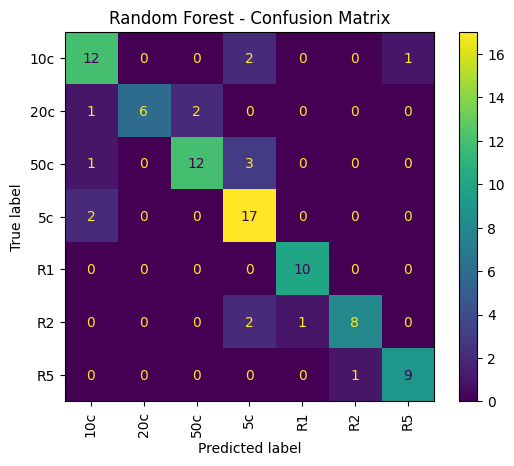


=== K-Nearest Neighbors ===
Accuracy: 0.8444444444444444
              precision    recall  f1-score   support

         10c       0.80      0.80      0.80        15
         20c       1.00      0.89      0.94         9
         50c       0.74      0.88      0.80        16
          5c       0.89      0.84      0.86        19
          R1       0.90      0.90      0.90        10
          R2       0.80      0.73      0.76        11
          R5       0.90      0.90      0.90        10

    accuracy                           0.84        90
   macro avg       0.86      0.85      0.85        90
weighted avg       0.85      0.84      0.85        90



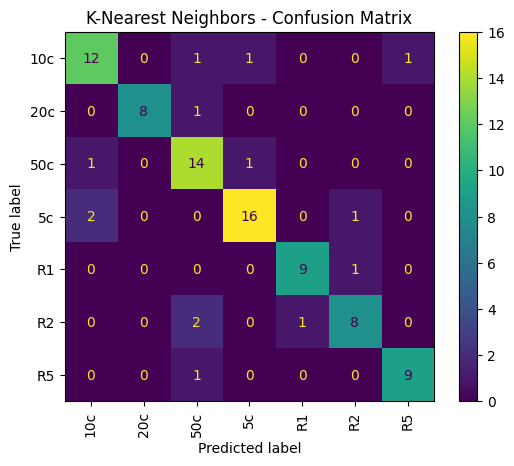


=== Decision Tree ===
Accuracy: 0.5222222222222223
              precision    recall  f1-score   support

         10c       0.50      0.40      0.44        15
         20c       0.27      0.33      0.30         9
         50c       0.53      0.56      0.55        16
          5c       0.60      0.63      0.62        19
          R1       0.57      0.40      0.47        10
          R2       0.42      0.45      0.43        11
          R5       0.73      0.80      0.76        10

    accuracy                           0.52        90
   macro avg       0.52      0.51      0.51        90
weighted avg       0.53      0.52      0.52        90



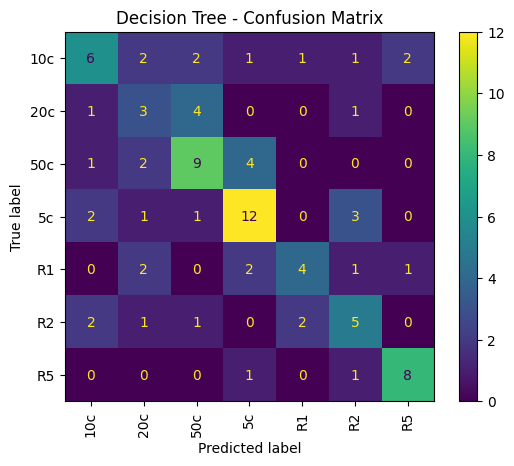


=== SVM (RBF Kernel) ===
Accuracy: 0.9222222222222223
              precision    recall  f1-score   support

         10c       0.87      0.87      0.87        15
         20c       0.90      1.00      0.95         9
         50c       0.82      0.88      0.85        16
          5c       0.95      0.95      0.95        19
          R1       1.00      1.00      1.00        10
          R2       1.00      0.82      0.90        11
          R5       1.00      1.00      1.00        10

    accuracy                           0.92        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.93      0.92      0.92        90



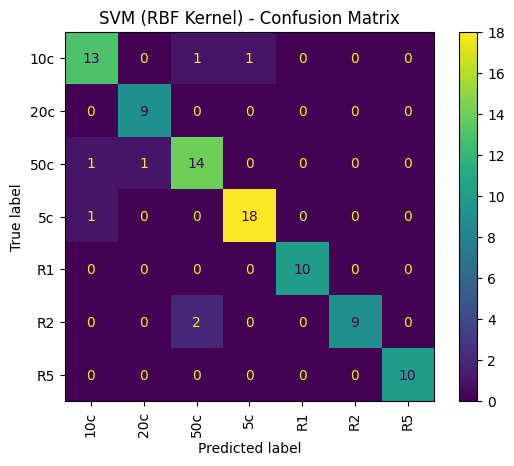

In [ ]:
# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset
X_img_train, X_img_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X, X_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Store models and names
models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=2,
                                            max_features='sqrt', n_jobs=-1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(max_depth=15, min_samples_split=2, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=10, gamma='scale',random_state=42)
}

# Loop through models
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_feat_train, y_train)
    y_pred = model.predict(X_feat_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(xticks_rotation='vertical')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()



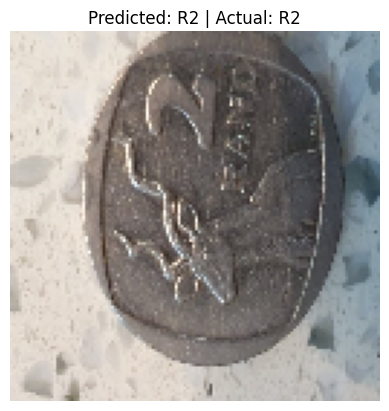

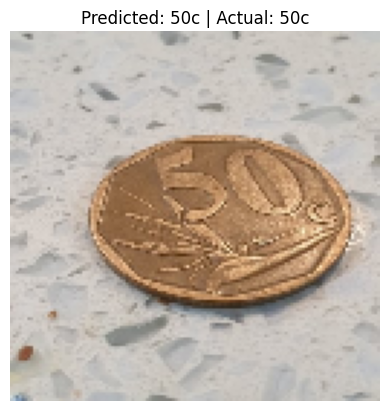

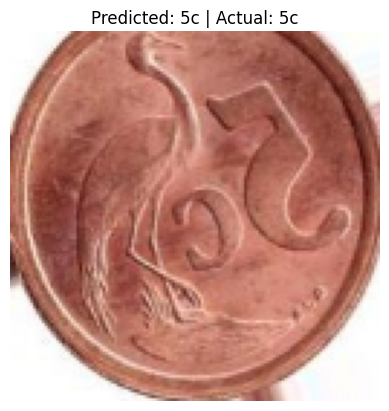

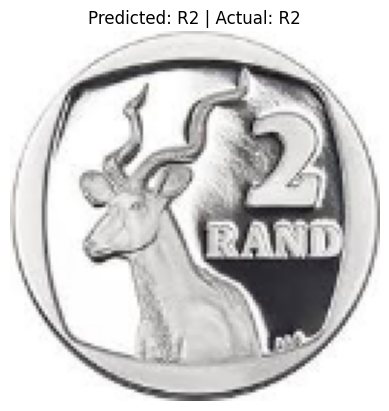

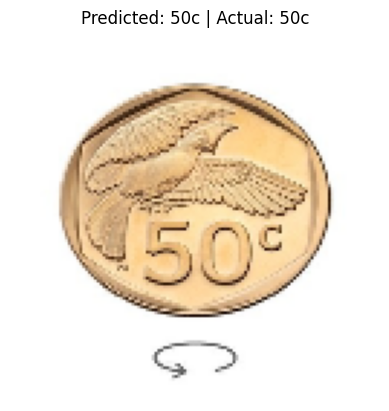

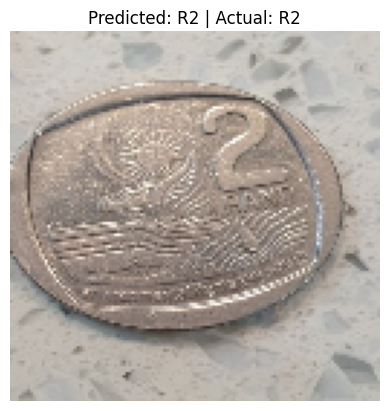

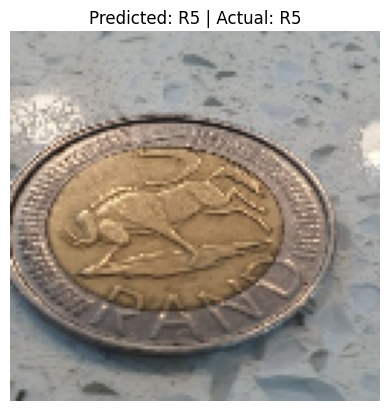

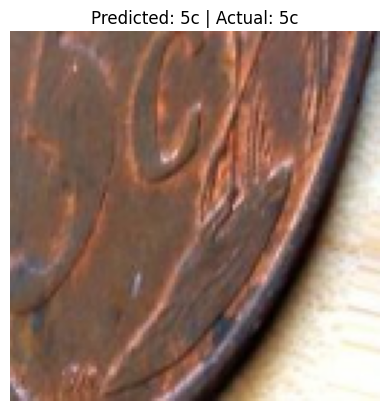

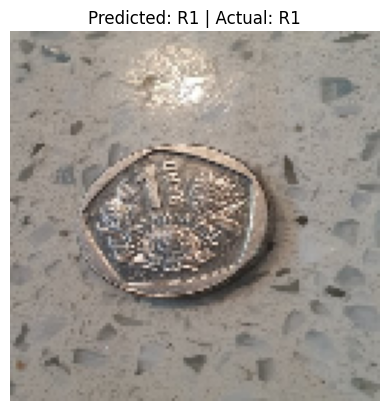

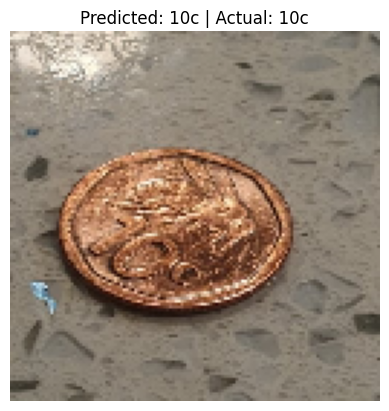

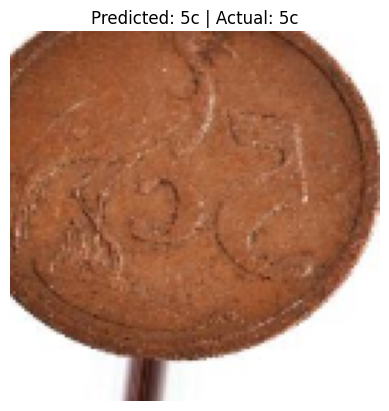

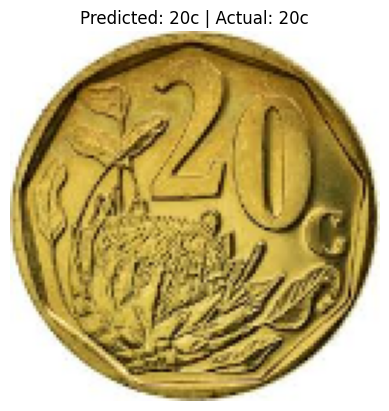

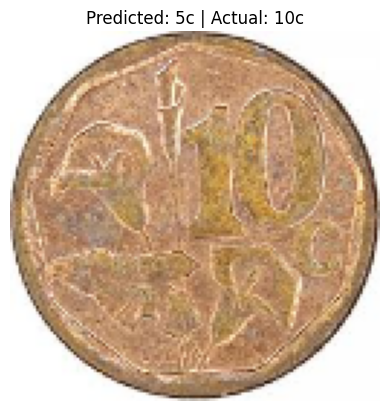

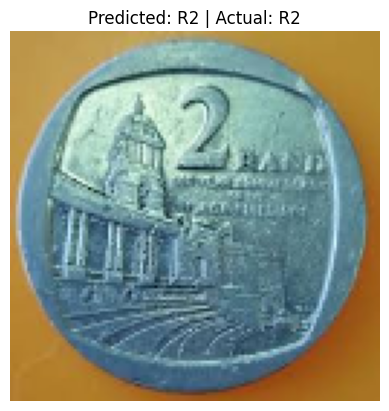

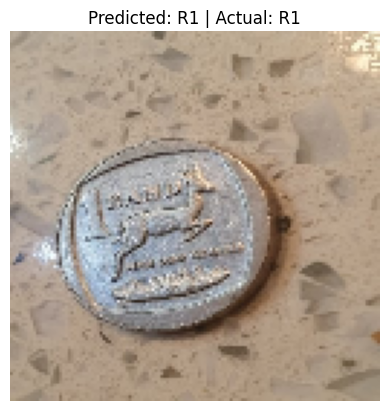

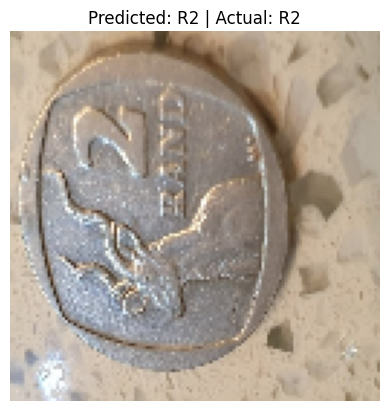

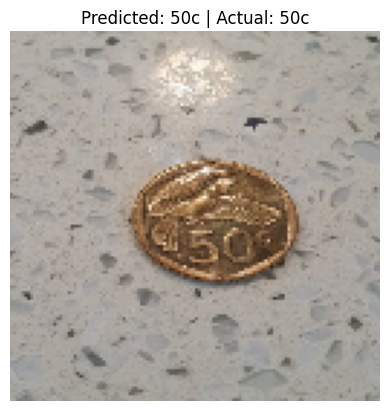

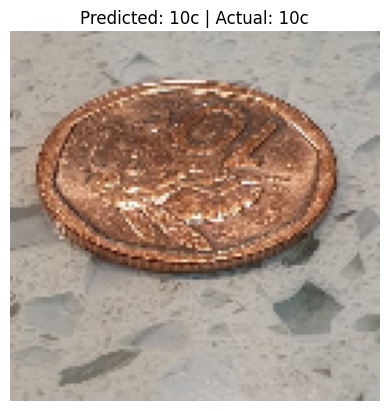

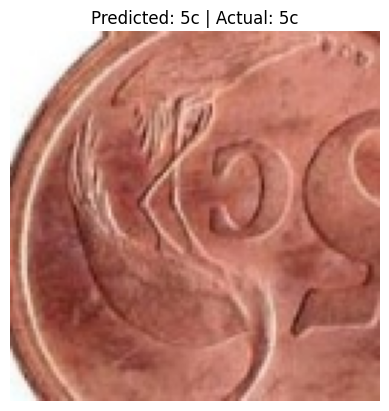

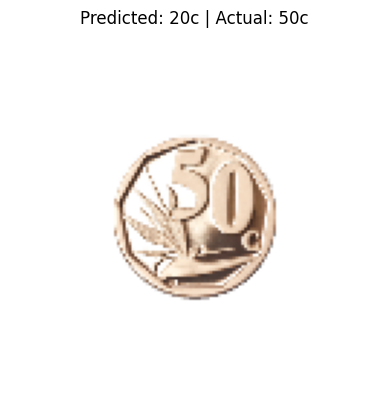

In [ ]:
# Visualize some predictions
import random
idx = 0
for i in range (idx,idx+20):
 original_img = X_img_test[i]
 plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
 pred_label = le.inverse_transform([y_pred[i]])[0]
 true_label = le.inverse_transform([y_test[i]])[0]
 plt.title(f"Predicted: {pred_label} | Actual: {true_label}")
 plt.axis('off')
 plt.show()





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


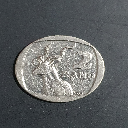


Predictions:
KNN: ['R2']
Random Forest: ['R2']
SVM (RBF): ['R2']


In [ ]:
import cv2
import numpy as np

# Load and preprocess image
img = cv2.imread("R2Test.jpg")
img_resized = cv2.resize(img, (128, 128))
img_proc = preprocess_image(img_resized)

# Segment the coin
img_segmented, _ = segment_coin(img_proc['blurred'], img_proc['original'])

# Extract features
img_features = extract_cnn_features(img_segmented)

# Show the segmented coin
cv2_imshow(img_resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Predict with trained models
img_pred1 = models['K-Nearest Neighbors'].predict(img_features.reshape(1, -1))
img_pred2 = models['Random Forest'].predict(img_features.reshape(1, -1))
img_pred3 = models['SVM (RBF Kernel)'].predict(img_features.reshape(1, -1))

# Decode predictions
print("\nPredictions:")
print("KNN:", le.inverse_transform(img_pred1))
print("Random Forest:", le.inverse_transform(img_pred2))
print("SVM (RBF):", le.inverse_transform(img_pred3))
